# np.identify    state: np.identity(16)[s1:s1 + 1]

In [5]:
import numpy as np

In [4]:
print(np.identity(16))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [6]:
print(np.identity(16)[0:1])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [7]:
print(np.eye(16)[10:11])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Percent of successful episodes: 0.4535%


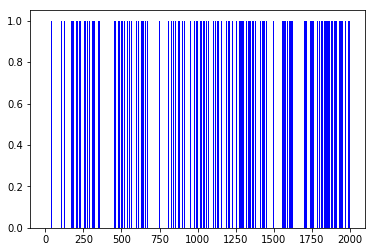

In [1]:
'''
This code is based on
https://github.com/hunkim/DeepRL-Agents
'''
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline



env = gym.make('FrozenLake-v0')


# Input and output size based on the Env
input_size = env.observation_space.n # 16
output_size = env.action_space.n     #  4
learning_rate = 0.1

# These lines establish the feed-forward part of the network used to
# choose actions
# 1 hidden layer
X = tf.placeholder(shape=[1, input_size], dtype=tf.float32)  # state input
W = tf.Variable(tf.random_uniform(
    [input_size, output_size], 0, 0.01))  # weight

Qpred = tf.matmul(X, W)  # Out Q prediction 추측값
Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32)  # Y label

loss = tf.reduce_sum(tf.square(Y - Qpred))
train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

# Set Q-learning related parameters
dis = .99
num_episodes = 2000

# Create lists to contain total rewards and steps per episode
rList = []


def one_hot(x):
    return np.identity(16)[x:x + 1]

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # Reset environment and get first new observation
        s = env.reset()
        e = 1. / ((i / 50) + 10)
        rAll = 0
        done = False
        local_loss = []

        # The Q-Network training
        while not done:
            # Choose an action by greedily (with e chance of random action)
            # from the Q-network
            Qs = sess.run(Qpred, feed_dict={X: one_hot(s)})
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)

            # Get new state and reward from environment
            s1, reward, done, _ = env.step(a)
            if done:
                # Update Q, and no Qs+1, since it's a terminal state
                Qs[0, a] = reward
            else:
                # Obtain the Q_s1 values by feeding the new state through our
                # network
                Qs1 = sess.run(Qpred, feed_dict={X: one_hot(s1)})
                # Update Q
                Qs[0, a] = reward + dis * np.max(Qs1)

            # Train our network using target (Y) and predicted Q (Qpred) values
            sess.run(train, feed_dict={X: one_hot(s), Y: Qs})

            rAll += reward
            s = s1
        rList.append(rAll)

print("Percent of successful episodes: " +
      str(sum(rList) / num_episodes) + "%")
plt.bar(range(len(rList)), rList, color="blue")
plt.show()
